In [1]:
#Luke Walker
#SDCND P3 Behavioral Cloning

#Imports
import cv2
import csv
import numpy as np
import os
import sklearn

#Model Imports
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Function Defintions

In [2]:
#Get Lines
def getLines(dataPath):
    """
    Returns each line from driving log
    """
    lines = []
    with open(dataPath + '/driving_log.csv') as csvFile:
        reader = csv.reader(csvFile)
        for line in reader:
            lines.append(line)
    return lines

In [3]:
#Get Images
def getImages(dataPath):
    """
    Returns center left and right images
    """
    directories = [x[0] for x in os.walk(dataPath)]
    dataDirectories = list(filter(lambda directory: os.path.isfile(directory + '/driving_log.csv'), directories))
    centerAll = []
    leftAll = []
    rightAll = []
    measurementAll = []
    for directory in dataDirectories:
        lines = getLines(directory)
        center = []
        left = []
        right = []
        measurements = []
        for line in lines:
            measurements.append(float(line[3]))
            center.append(directory + '/' + line[0].strip())
            left.append(directory + '/' + line[1].strip())
            right.append(directory + '/' + line[2].strip())
        centerAll.extend(center)
        leftAll.extend(left)
        rightAll.extend(right)
        measurementAll.extend(measurements)

    return (centerAll, leftAll, rightAll, measurementAll)

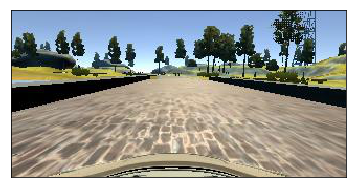

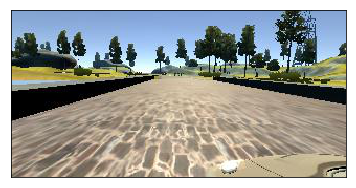

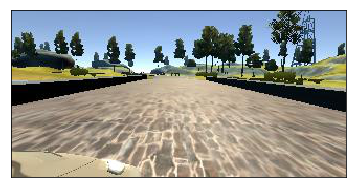

In [29]:
#Look at center, left, and right image#Put images into single array
centerAll, leftAll, rightAll, measurementAll = getImages('data')

center = cv2.imread(centerAll[0])
center = cv2.cvtColor(center, cv2.COLOR_BGR2RGB)

left = cv2.imread(leftAll[0])
left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)

right = cv2.imread(rightAll[0])
right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)

plt.imshow(center)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

plt.imshow(left)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

plt.imshow(right)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()


In [30]:
def extendImages(center, left, right, measurement, offset):
    """
    Extends images to single array
    """
    imagePaths = []
    imagePaths.extend(center)
    imagePaths.extend(left)
    imagePaths.extend(right)
    measurements = []
    measurements.extend(measurement)
    measurements.extend([x + offset for x in measurement])
    measurements.extend([x - offset for x in measurement])
    return (imagePaths, measurements)

In [31]:
#Generator
def generator(samples, batch_size=32):
    """
    Generate the required images and angles for training
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator always runs
        samples = sklearn.utils.shuffle(samples)

        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []

            for imagePath, measurement in batch_samples:
                originalImage = cv2.imread(imagePath)
                image = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
                images.append(image)
                angles.append(measurement)
                #Flip and append
                images.append(cv2.flip(image,1))
                angles.append(measurement*-1.0)

            #trim images
            inputs = np.array(images)
            outputs = np.array(angles)

            #Yield and shuffle
            yield sklearn.utils.shuffle(inputs, outputs)

## Model Definiton

In [32]:
#Model definition
def modified_nVidea():
    """
    Creates modified nVidea model
    """
    #Sequential Model
    model = Sequential()
    #Lambda Layer
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
    #Cropping Layer
    model.add(Cropping2D(cropping=((50,20), (0,0)))) #remove top 50 pix and bottom 20 pix
    #5 Convolution Layers
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    #Flatten
    model.add(Flatten())
    #4 Dense Layers
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    #Return Model
    return model


In [33]:
# Reading images locations.
centerPaths, leftPaths, rightPaths, measurements = getImages('data')
imagePaths, measurements = extendImages(centerPaths, leftPaths, rightPaths, measurements, 0.2)
print('Total Images: {}'.format(len(imagePaths)))

#Splitting samples and creating generators.
from sklearn.model_selection import train_test_split
samples = list(zip(imagePaths, measurements))
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

#Show number of training and validation samples
print('Train samples: {}'.format(len(train_samples)))
print('Validation samples: {}'.format(len(validation_samples)))

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

Total Images: 24108
Train samples: 19286
Validation samples: 4822


In [34]:
#Build the model
model = modified_nVidea()

In [35]:
# Compiling and training the model
model.compile(loss='mse', optimizer='adam')
run_model = model.fit_generator(train_generator, samples_per_epoch= \
                 len(train_samples), validation_data=validation_generator, \
                 nb_val_samples=len(validation_samples), nb_epoch=3, verbose=1)

Epoch 1/3
19264/19286 [============================>.] - ETA: 1s - loss: 0.0206

/Users/lgwalker/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


19328/19286 [==============================] - 986s - loss: 0.0206 - val_loss: 0.0176
Epoch 2/3
19308/19286 [==============================] - 965s - loss: 0.0162 - val_loss: 0.0158
Epoch 3/3
19328/19286 [==============================] - 591s - loss: 0.0148 - val_loss: 0.0147


In [38]:
model.save('model_nNvidia_modified.h5')
print(run_model.history.keys())
print('Loss')
print(run_model.history['loss'])
print('Validation Loss')
print(run_model.history['val_loss'])
print('Model Summary')


dict_keys(['val_loss', 'loss'])
Loss
[0.020609314403872911, 0.016221245915169966, 0.014779404621410943]
Validation Loss
[0.01755475845972174, 0.015777025353332672, 0.014720077914381889]
Model Summary


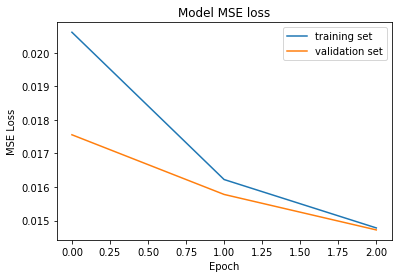

In [40]:
plt.plot(run_model.history['loss'])
plt.plot(run_model.history['val_loss'])
plt.title('Model MSE loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [41]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 43, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 20, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________